In [1]:
import pandas as pd
import numpy as np
#import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab  
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from scipy.interpolate import interp1d

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
def intepmod1D(y):
    N=59
    dep=[]
    s=0.0
    for i in range(N):
        dep.append(s)
        if(i<20):
            s=s+0.2
        elif(i<40):
            s=s+1
        else:
            s=s+2.0 
    
    #print(len(x),len(y))
    cs = interp1d(dep, y,kind='cubic')
    xs = np.linspace(0,60,80)
    ys=cs(xs)
    return ys

def intepsw1D(y):
    x=np.linspace(4, 34, 16)
    #print(len(x),len(y))
    cs = interp1d(x, y,kind='cubic')
    xs = np.linspace(4,34,80)
    ys=cs(xs)
    #print(x)
    return ys
def inteprftn(y):
    x=np.linspace(0, 299, 299)
    #print(len(x),len(y))
    cs = interp1d(x, y,kind='cubic')
    xs = np.linspace(0,299,80)
    ys=cs(xs)
    #print(x)
    return ys
def get_tran_test_data(data):   
    X_sw=[]
    X_rf=[]
    y_train=[]
    k=0

    for index in data.index:
        swdata=data.loc[index,'swdata']      
        swdata=np.asfarray(swdata.split(','))
        rfdata=data.loc[index,'rftndata']      
        rfdata=np.asfarray(rfdata.split(','))
        #rftndata=rftn_reduce(rftndata)
        swdata=intepsw1D(swdata)
        rfdata=inteprftn(rfdata)
        mtmodel=data.loc[index,'modeldata']     
        mtmodel=np.asfarray(mtmodel.split(','))
        mtmodel=intepmod1D(mtmodel)
        #rftndata=rftn_reduce(rftndata)
        #X_train.append(np.hstack((rftndata,swdata)))

        X_sw.append(swdata)
        X_rf.append(rfdata)
        y_train.append(mtmodel)
     
    X_rf=np.array(X_rf)
    X_sw=np.array(X_sw)
    y_train=np.array(y_train)

    return X_rf,X_sw,y_train


def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [4]:
n_outputs1=80
smooth_marix=np.zeros((n_outputs1,n_outputs1))
for i in range(len(smooth_marix)-1):
    smooth_marix[i][i]=1
    smooth_marix[i][i+1]=-1
smooth_marix[-1][-2]=1
smooth_marix[-1][-1]=-1
smooth_marix=np.dot(np.transpose(smooth_marix), smooth_marix)

class neuralNetwork:
    def __init__(self):
        
        self.height =80
        self.width = 1
        self.channels = 2
        self.n_inputs = self.height * self.width
        self.n_outputs=80
        #self.drop=0.8
    def convolution_layer(self,X,conv1_fmaps,drop,lay_name):
        conv = tf.layers.conv2d(X, filters=conv1_fmaps, kernel_size=[4,1],
                         strides=1, padding="SAME",activation=tf.nn.elu, name=lay_name)
        
        conv_drop=tf.nn.dropout(conv,drop)
        return conv_drop
    
    def trans_convlution_layer(self,X,fmaps,lay_name):
        t_conv = tf.layers.conv2d_transpose(X,filters=fmaps, kernel_size=[3,1],
                                    strides=[2,1], padding="SAME",name=lay_name)
                                     
        return t_conv
        
    def forward(self):
        with tf.name_scope("inputs"):
            self.X = tf.placeholder(tf.float32, shape=[None, self.height, self.width, self.channels], name="X")
            self.y = tf.placeholder(tf.float32, shape=[None,self.n_outputs], name="y")
            self.alpha=tf.placeholder(tf.float32, shape=(), name="alpha")
            self.keep_prob= tf.placeholder(tf.float32, shape=(), name="regularizer")
           
        self.L12=self.convolution_layer(self.X,32,1,'layerL12')
        self.L13=self.convolution_layer(self.L12,32,1,'layerL13')
        
        self.L21 = tf.nn.max_pool(self.L13, ksize=[1, 2, 1, 1], strides=[1, 2, 1, 1],padding="SAME")
        self.L22=self.convolution_layer(self.L21,64,self.keep_prob,'layerL22')
        self.L23=self.convolution_layer(self.L22,64,self.keep_prob,'layerL23')
        
        self.L31 = tf.nn.max_pool(self.L23, ksize=[1, 2, 1, 1], strides=[1, 2, 1, 1],padding="SAME")
        self.L32=self.convolution_layer(self.L31,128,self.keep_prob,'layerL32')
        self.L33=self.convolution_layer(self.L32,128,self.keep_prob,'layerL33')
        
        self.L41 = tf.nn.max_pool(self.L33, ksize=[1, 2, 1, 1], strides=[1, 2, 1, 1],padding="SAME")
        self.L42=self.convolution_layer(self.L41,256,self.keep_prob,'layerL42')
        self.L43=self.convolution_layer(self.L42,256,self.keep_prob,'layerL43')
        
#         self.L51 = tf.nn.max_pool(self.L43, ksize=[1, 2, 1, 1], strides=[1, 2, 1, 1],padding="SAME")
#         self.L52=self.convolution_layer(self.L51,512,self.keep_prob,'layerL52')
#         self.L53=self.convolution_layer(self.L52,512,self.keep_prob,'layerL53')
        
#         self.R41=self.trans_convlution_layer(self.L53,256,'layerR41')
#         self.R41=tf.concat([self.L43, self.R41], 3)
#         self.R42=self.convolution_layer(self.R41,256,self.keep_prob,'layerR42')
#         self.R43=self.convolution_layer(self.R42,256,self.keep_prob,'layerR43')
        
        self.R31=self.trans_convlution_layer(self.L43,128,'layerR31')
        self.R31=tf.concat([self.L33, self.R31], 3)
        self.R32=self.convolution_layer(self.R31,128,1,'layerR32')
        self.R33=self.convolution_layer(self.R32,128,1,'layerR33')
        
        self.R21=self.trans_convlution_layer(self.R33,64,'layerR21')
        self.R21=tf.concat([self.L23, self.R21], 3)
        self.R22=self.convolution_layer(self.R21,64,1,'layerR22')
        self.R23=self.convolution_layer(self.R22,64,1,'layerR23')
        
        self.R11=self.trans_convlution_layer(self.R23,32,'layerR11')
        self.R11=tf.concat([self.L13, self.R11], 3)
        self.R12=self.convolution_layer(self.R11,64,1,'layerR12')
        self.R13=self.convolution_layer(self.R12,32,1,'layerR13')
        self.R14=self.convolution_layer(self.R13,16,1,'layerR14')
        self.R15=self.convolution_layer(self.R14,1,1,'layerR15')
        
        with tf.name_scope("train"):
            self.smooth_marix=tf.constant(np.transpose(smooth_marix),dtype=tf.float32)
            self.output=tf.reshape(self.R15, shape=[-1, self.height])
            self.sm=tf.reduce_mean(tf.square(tf.matmul(self.output, self.smooth_marix)),axis=1)
            self.loss1=tf.reduce_mean(tf.square(self.output - self.y),axis=1)
            self.loss = tf.reduce_mean(self.loss1+self.alpha*self.sm)
            optimizer = tf.train.AdamOptimizer()
            self.training_op = optimizer.minimize(self.loss)
        pass

In [5]:
def contact_tier(Xmt_resdata,Xmt_phadata):
    height = 80
    width = 1
    channels = 1
    tier1=np.array(([(i+1)*0.1 for i in range(80)])*Xmt_resdata.shape[0])
    tier1=tier1.reshape(-1,height,width,channels)
    #Xsw_data=Xsw_data.reshape(-1,height,width,channels)
    Xmt_resdata=Xmt_resdata.reshape(-1,height,width,channels)
    #Xmt_phadata=Xmt_phadata.reshape(-1,height,width,channels)
    print(Xmt_resdata.shape,Xmt_phadata.shape)
    data1=np.concatenate((Xmt_resdata,tier1),axis=3)
    return data1

In [22]:
alldata=pd.read_csv('traindata_4.25.dat',sep=',',header=0,index_col=0)
data_train,data_test=train_test_split(alldata,test_size=0.1)

In [23]:
X_train_rf,X_train_sw,y_train=get_tran_test_data(data_train)
X_train=contact_tier(X_train_rf,X_train_sw)
X_test_rf,X_test_sw,y_test=get_tran_test_data(data_test)
X_test=contact_tier(X_test_rf,X_test_sw)

(53999, 80, 1, 1) (53999, 80)
(6000, 80, 1, 1) (6000, 80)


In [24]:
X_train.shape

(53999, 80, 1, 2)

In [25]:
tf.reset_default_graph()
Unet_seis=neuralNetwork()

Unet_seis.forward()
sess = tf.Session()
sess.run(tf.global_variables_initializer())



In [26]:
tem = sess.run(Unet_seis.X,feed_dict={Unet_seis.X:X_test,Unet_seis.y:y_test,Unet_seis.alpha:1,Unet_seis.keep_prob:1})
tem.shape

(6000, 80, 1, 2)

In [27]:
batch_size = 600
nepoch=80
alpha=0.3
f=open('loss.dat','w')
for epoch in range(nepoch):
    #tem = sess.run(DNN_eq.loss,feed_dict={DNN_eq.X: X_train,DNN_eq.y:y_train})
    #print(tem)
    
    loss_train = sess.run(Unet_seis.loss,feed_dict={Unet_seis.X: X_train,Unet_seis.y:y_train,Unet_seis.alpha:alpha,Unet_seis.keep_prob:1})
    loss_test = sess.run(Unet_seis.loss,feed_dict={Unet_seis.X: X_test,Unet_seis.y:y_test,Unet_seis.alpha:alpha,Unet_seis.keep_prob:1})
    f.write('%d %f %f %f\n' %(epoch,loss_train,loss_test,alpha))
    
    print(epoch,loss_train,loss_test,alpha)
    if(loss_train<0.01):
        break
    for X_batch, y_batch in shuffle_batch(X_train,y_train, batch_size):
        sess.run(Unet_seis.training_op,feed_dict={Unet_seis.X: X_batch,Unet_seis.y:y_batch,Unet_seis.alpha:alpha,Unet_seis.keep_prob:0.8})
    #alpha=alpha*0.5
f.close()

0 15.460921 15.461484 0.3
1 0.06744561 0.06794806 0.3
2 0.06666305 0.06717342 0.3
3 0.06673689 0.0672401 0.3
4 0.067667045 0.06818162 0.3
5 0.0663679 0.06687914 0.3
6 0.06634427 0.06684912 0.3
7 0.066609785 0.06712433 0.3
8 0.066091865 0.0665844 0.3
9 0.06929506 0.06978453 0.3
10 0.06845021 0.06893284 0.3
11 0.06666416 0.067153096 0.3
12 0.06580489 0.06629438 0.3
13 0.06579452 0.06628303 0.3
14 0.06736226 0.067850925 0.3
15 0.06680686 0.067265905 0.3
16 0.068429515 0.068969205 0.3
17 0.06017199 0.06058126 0.3
18 0.07965205 0.07988382 0.3
19 0.03236256 0.032338493 0.3
20 0.02901252 0.02898617 0.3
21 0.028517572 0.028481333 0.3
22 0.026654208 0.026671167 0.3
23 0.025330484 0.025433354 0.3
24 0.03022681 0.030398142 0.3
25 0.02437418 0.024471408 0.3
26 0.023749407 0.023840973 0.3
27 0.021864403 0.021982953 0.3
28 0.020959752 0.021144528 0.3
29 0.019609459 0.019825831 0.3
30 0.022286627 0.022471258 0.3
31 0.01947402 0.019671535 0.3
32 0.018474942 0.01860621 0.3
33 0.0211666 0.021350687 0.3


KeyboardInterrupt: 

In [31]:
saver=tf.train.Saver()
saver.save(sess,'Unetmodel/Unet_seis12.27.ckpt')

'Unetmodel/Unet_seis12.27.ckpt'

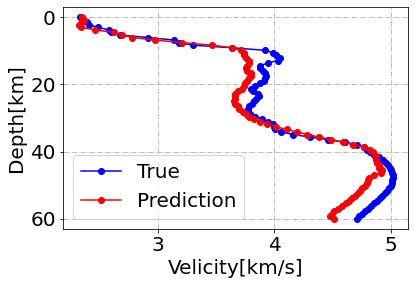

In [29]:
y_predi = sess.run(Unet_seis.output,feed_dict={Unet_seis.X: X_test,Unet_seis.y:y_test,Unet_seis.keep_prob:1})
N=59
dep1=[]
vel1=[0 for i in  range(N)]
s=0
for i in range(N):
    dep1.append(s)
    if(i<20):
        s=s+0.2
    elif(i<40):
        s=s+1
    else:
        s=s+2.0   
    xs = np.linspace(0,60,80)
for i in range(100):
    plt.cla()  
    ax=plt.gca()
    plt.xlabel('Velicity[km/s]',fontsize=20)
    plt.ylabel('Depth[km]',fontsize=20)
    plt.grid(linestyle='-.')
    plt.tick_params(labelsize=20)
    ax.invert_yaxis()
    plt.subplots_adjust(top=0.95,bottom=0.18,left=0.17,right=0.97)
    line1,=plt.plot(y_test[i],xs,linewidth=1.5,marker='o',color='blue')
    line2,=plt.plot(y_predi[i],xs,linewidth=1.5,marker='o',color='red')
    ll=plt.legend([line1,line2],['True',"Prediction"],loc='lower left',fontsize=20)
    plt.savefig('plot/'+str(i)+'.png',dpi=(150.0))

(1000, 80)


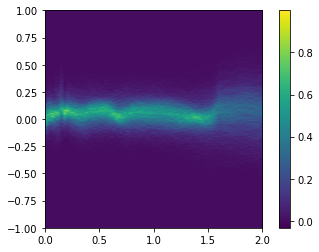

In [30]:
y_predi = sess.run(Unet_seis.output,feed_dict={Unet_seis.X: X_test,Unet_seis.y:y_test,Unet_seis.keep_prob:1})
from scipy import interpolate 
N=5000
N1=1000
N2=80
proba=[[0 for i in range(N2)] for j in range(N1)]
proba=np.array(proba)
de=2.0/N1
for i in range(N):
    tem=y_predi[i]-y_test[i]
    for j in range(len(tem)):
        if(tem[j]>-1 and tem[j]<1):
            k=int(tem[j]/de+N1/2)
            #print(k)
            proba[k][j]=proba[k][j]+1
max1=np.max(proba)            
print(proba.shape)
proba=proba/max1

dep=np.linspace(0,60,80)
err=np.linspace(-1,1,1000)
newfunc = interpolate.interp2d(dep, err, proba, kind='cubic') 

xnew = np.linspace(0,60,2000)#x 
ynew = np.linspace(-1,1,2000)#y 
fnew = newfunc(xnew, ynew)
im1=plt.imshow(fnew,extent=[0,2,-1,1])
plt.colorbar(im1) 
plt.show()

In [39]:
f=open('proba.dat','w')
for i in range(N1):
    for j in range(N2):
        f.write('%f '%(proba[i][j]))
    f.write('\n')
f.close()